In [ ]:
# pip install -U datasets


In [2]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

/mnt/d/code/slm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating validation split: 100%|██████████| 21990/21990 [00:00<00:00, 420303.88 examples/s]


In [3]:
# !pip install tiktoken
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

def process(example):
    ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

writing validation.bin: 100%|██████████| 1024/1024 [00:08<00:00, 126.21it/s]


In [ ]:

def get_batch(split):
   
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


## Step 4: Define the SLM Model Architecture

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx



In [ ]:
config = GPTConfig(
    vocab_size=50257,     
    block_size=128,       
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

## Step 5: Define the loss function

In [10]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

## Step 6: Define SLM Training Configuration Part 1

In [ ]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 
max_iters = 20000 
warmup_steps = 1000 
min_lr = 5e-4 
eval_iters = 500 
batch_size = 32 
block_size = 128 

gradient_accumulation_steps = 32 

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' 



dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' 
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

## Step 7: Define SLM Training Configuration Part 2

In [ ]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) 

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) 
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) 

scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipykernel_3715/2132813893.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


## Step 8: Pre-train the SLM

In [ ]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []


model = model.to(device)


for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

   
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/20000 [00:00<?, ?it/s]/mnt/d/code/slm/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  2%|▏         | 499/20000 [00:52<33:11,  9.79it/s]  

Epoch 500: train loss 9.4529, val loss 9.4577
The current learning rate: 0.00007


  5%|▍         | 998/20000 [02:35<30:59, 10.22it/s]   /mnt/d/code/slm/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  5%|▌         | 1000/20000 [02:47<30:53, 10.25it/s]

Epoch 1000: train loss 8.4765, val loss 8.4795
The current learning rate: 0.00010


  8%|▊         | 1500/20000 [04:27<28:52, 10.68it/s]   

Epoch 1500: train loss 7.5284, val loss 7.5297
The current learning rate: 0.00010


 10%|▉         | 1999/20000 [06:10<29:09, 10.29it/s]   

Epoch 2000: train loss 6.6814, val loss 6.6826
The current learning rate: 0.00010


 12%|█▎        | 2500/20000 [07:47<29:26,  9.91it/s]   

Epoch 2500: train loss 5.9812, val loss 5.9793
The current learning rate: 0.00011


 15%|█▍        | 2999/20000 [09:27<27:14, 10.40it/s]   

Epoch 3000: train loss 5.4655, val loss 5.4652
The current learning rate: 0.00011


 18%|█▊        | 3500/20000 [11:10<25:54, 10.61it/s]   

Epoch 3500: train loss 5.0471, val loss 5.0396
The current learning rate: 0.00012


 20%|██        | 4000/20000 [12:36<27:32,  9.68it/s]   

Epoch 4000: train loss 4.7213, val loss 4.7193
The current learning rate: 0.00012


 22%|██▎       | 4500/20000 [14:25<23:17, 11.09it/s]   

Epoch 4500: train loss 4.4749, val loss 4.4781
The current learning rate: 0.00013


 25%|██▌       | 5000/20000 [16:10<23:10, 10.79it/s]   

Epoch 5000: train loss 4.2653, val loss 4.2686
The current learning rate: 0.00014


 27%|██▋       | 5499/20000 [17:54<23:40, 10.21it/s]   

Epoch 5500: train loss 4.1031, val loss 4.1022
The current learning rate: 0.00015


 30%|███       | 6000/20000 [19:26<22:42, 10.28it/s]   

Epoch 6000: train loss 3.9575, val loss 3.9521
The current learning rate: 0.00016


 32%|███▎      | 6500/20000 [21:09<21:44, 10.35it/s]   

Epoch 6500: train loss 3.8209, val loss 3.8217
The current learning rate: 0.00018


 35%|███▍      | 6999/20000 [22:46<20:46, 10.43it/s]   

Epoch 7000: train loss 3.7028, val loss 3.7100
The current learning rate: 0.00019


 38%|███▊      | 7500/20000 [24:26<19:11, 10.86it/s]   

Epoch 7500: train loss 3.5862, val loss 3.5888
The current learning rate: 0.00020


 40%|████      | 8000/20000 [26:10<19:50, 10.08it/s]   

Epoch 8000: train loss 3.4912, val loss 3.4985
The current learning rate: 0.00022


 42%|████▎     | 8500/20000 [27:48<17:56, 10.68it/s]   

Epoch 8500: train loss 3.4102, val loss 3.4129
The current learning rate: 0.00024


 45%|████▌     | 9000/20000 [29:28<17:51, 10.26it/s]   

Epoch 9000: train loss 3.3384, val loss 3.3392
The current learning rate: 0.00025


 47%|████▋     | 9499/20000 [31:12<16:35, 10.55it/s]   

Epoch 9500: train loss 3.2454, val loss 3.2548
The current learning rate: 0.00027


 50%|█████     | 10000/20000 [32:49<15:43, 10.59it/s]  

Epoch 10000: train loss 3.1761, val loss 3.1833
The current learning rate: 0.00028


 52%|█████▏    | 10499/20000 [34:29<14:38, 10.82it/s]   

Epoch 10500: train loss 3.1074, val loss 3.1108
The current learning rate: 0.00030


 55%|█████▌    | 11000/20000 [36:07<14:06, 10.63it/s]   

Epoch 11000: train loss 3.0514, val loss 3.0489
The current learning rate: 0.00032


 57%|█████▋    | 11499/20000 [37:47<13:42, 10.34it/s]   

Epoch 11500: train loss 3.0004, val loss 3.0054
The current learning rate: 0.00033


 60%|██████    | 12000/20000 [39:14<15:33,  8.57it/s]   

Epoch 12000: train loss 2.9396, val loss 2.9417
The current learning rate: 0.00035


 62%|██████▎   | 12500/20000 [40:55<24:57,  5.01it/s]   

Epoch 12500: train loss 2.8873, val loss 2.8931
The current learning rate: 0.00036


 65%|██████▌   | 13000/20000 [42:50<11:29, 10.15it/s]   

Epoch 13000: train loss 2.8438, val loss 2.8422
The current learning rate: 0.00038


 68%|██████▊   | 13500/20000 [44:24<10:10, 10.66it/s]   

Epoch 13500: train loss 2.7954, val loss 2.8022
The current learning rate: 0.00040


 70%|██████▉   | 13999/20000 [46:08<09:31, 10.50it/s]   

Epoch 14000: train loss 2.7568, val loss 2.7605
The current learning rate: 0.00041


 72%|███████▏  | 14499/20000 [47:46<08:55, 10.27it/s]   

Epoch 14500: train loss 2.7117, val loss 2.7172
The current learning rate: 0.00042


 75%|███████▍  | 14999/20000 [49:26<07:49, 10.65it/s]   

Epoch 15000: train loss 2.6675, val loss 2.6724
The current learning rate: 0.00044


 78%|███████▊  | 15500/20000 [51:10<07:01, 10.67it/s]   

Epoch 15500: train loss 2.6207, val loss 2.6269
The current learning rate: 0.00045


 80%|████████  | 16000/20000 [52:33<06:51,  9.71it/s]   

Epoch 16000: train loss 2.5895, val loss 2.5968
The current learning rate: 0.00046


 82%|████████▏ | 16499/20000 [54:28<05:19, 10.97it/s]   

Epoch 16500: train loss 2.5539, val loss 2.5588
The current learning rate: 0.00047


 85%|████████▌ | 17000/20000 [56:05<04:44, 10.55it/s]  

Epoch 17000: train loss 2.5214, val loss 2.5237
The current learning rate: 0.00048


 87%|████████▋ | 17499/20000 [57:45<04:01, 10.34it/s]  

Epoch 17500: train loss 2.4912, val loss 2.4994
The current learning rate: 0.00048


 90%|█████████ | 18000/20000 [59:29<03:13, 10.32it/s]  

Epoch 18000: train loss 2.4671, val loss 2.4796
The current learning rate: 0.00049


 92%|█████████▏| 18499/20000 [1:01:07<02:20, 10.66it/s]  

Epoch 18500: train loss 2.4333, val loss 2.4392
The current learning rate: 0.00049


 95%|█████████▌| 19000/20000 [1:02:48<01:36, 10.39it/s]  

Epoch 19000: train loss 2.4025, val loss 2.4106
The current learning rate: 0.00050


 98%|█████████▊| 19500/20000 [1:04:26<00:44, 11.17it/s]  

Epoch 19500: train loss 2.3840, val loss 2.3928
The current learning rate: 0.00050


100%|██████████| 20000/20000 [1:05:55<00:00,  5.06it/s]  


## Step 9: Plot the SLM Loss Function

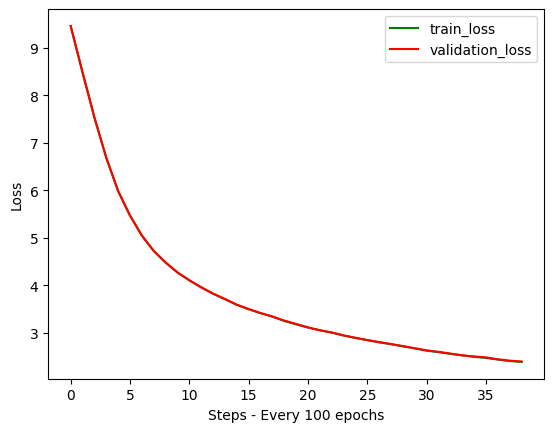

In [15]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



## Step 10: Run SLM Inference on our trained model

In [ ]:

model = GPT(config)  
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [ ]:
sentence = "Once upon a time there was a pumpkin."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin. It was very special. The pumpkin wanted to paint with its family. So one day, a family decided to make it you all the time. They worked hard to remove something.

 2 laser soldiers traveled and drove it grow into the sky. laughed like the whole."

The pumpkin stopped and smiled and felt happy for the tube. It sounded like it. Give it on big taller than it. They packed it and back up.

When it was done, the pumpkin had closed. It was relaxed and cozy. There were people that flying. Little Thursday workerAlright, the tower could during a bright, normal time. His friend said, "Trn into Lou, what can we do and find our flashlight?"

Her friend thought smellyly and said: "We can try to open it! It can be alright. We can find it". 

Joe was amazed. He wanted that if they could delay, they would come back back and mattered the sign


In [24]:
sentence = "Anubhav went to school"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Anubhav went to school. He wanted to be polite and generous, so he had an opportunity to learn with his mom. 

"Well, I'm sorry," said Mrs. Smith replied when she saw her friend. Brown's at the desk, she hugged him and said, "You're welcometime, Flora. You must have to marry and keep you come from me, I will give you the police." 

So Blue and his friends introduced him to them. They learned that exploring and soon attached his sister was driving, it made of him the toys advantage.

The moral of being jolly, and its lesson, they still gave him food to bury by enough surprises.Once upon a time, there was a little girl named Maria. She was three years old and loved to play. One day she was only three years old and she was playing with her mommy so she went to learn. She went on a journey to find lots of coins that tried to find all small,
